#                     Semantic Image Segmentation for Autonomous Vehicles

Sementic image sementation is the process of dividing an image into different regions based on the characteristics of pixels to identify objects or boundaries to simplify an image. Segmentation impacts a number of domains, from the medical industry to the field of autonaumous driving.

In this project I'll segment the image taken by the front camera of the car by classifying each pixle

We'll use UNet, a convolutional neural network architecture that expanded with few changes in the CNN architecture. It was invented to deal with the images where the target is not only to classify whether there is an object present or not but also to identify its location in the given image

In [17]:
# Importing all the required libraries

import matplotlib.pyplot as plt #for visualizing
import cv2
from PIL import Image #for image loading and editing
import tensorflow as tf # For using UNet 
from sklearn.cluster import KMeans # for clustering
import os #for dealing with files
import re
import seaborn as sns #for visualizing
import numpy as np # for linear algebra operations
import pandas as pd

In [18]:
# creating a function to load the data
def Raw_data(name, path="../input/cityscapes_data/cityscapes_data/train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)


def get_images( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj
        
    
 
    
   

In [19]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

In [20]:
image_training_object = {'img' : [],
           'mask' : []
          }

image_validation_object = {'img' : [],
           'mask' : []
          }

In [21]:
image_training_object = get_images( image_training_object, imgPath = '/kaggle/input/camvid/CamVid/train', maskPath = '/kaggle/input/camvid/CamVid/train_labels'
         , shape = 256)

In [22]:
image_validation_object  = get_images( image_validation_object, imgPath = '/kaggle/input/camvid/CamVid/val', maskPath = '/kaggle/input/camvid/CamVid/val_labels'
         , shape = 256)

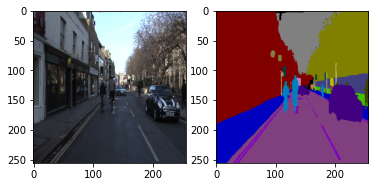

In [23]:
#Check for input data
plt.subplot(1,2,1)
plt.imshow(image_training_object['img'][1])
plt.subplot(1,2,2)
plt.imshow(image_training_object['mask'][1])
plt.show()

In [24]:
# Creating a UNet neural network

def UNet_function(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


def Unet_deepL(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):

    c1 = UNet_function(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = UNet_function(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = UNet_function(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = UNet_function(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = UNet_function(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    

    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = UNet_function(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = UNet_function(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = UNet_function(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = UNet_function(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


inputs = tf.keras.layers.Input((128, 128, 3))
myTransformer = Unet_deepL(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [25]:
## trainign our model
retVal = myTransformer.fit(np.array(image_training_object['img']), np.array(image_training_object['mask']), epochs = 150, verbose = 0)

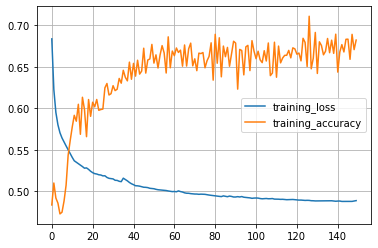

In [26]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [27]:
## Creating prediction functions
def make_prediction (valMap, model, shape = 256):
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Image_Plt(img, Predicted_Mask, actual_img):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(Predicted_Mask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(actual_img)
    plt.title('actual Mask')
    
    
    
    

In [30]:
predict_fnl, actuals, masks = make_prediction(image_validation_object, myTransformer)

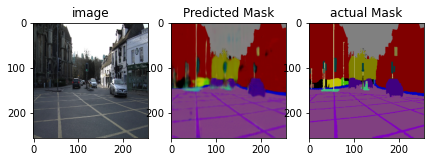

In [32]:
Image_Plt(actuals[4], predict_fnl[4], masks[4])